In [1]:
import json
import pickle
import os


from dynesty import NestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

import autolens as al
import autolens.plot as aplt

from plotbin.plot_velfield import plot_velfield
from jampy.mge_radial_mass import mge_radial_mass
from jampy.mge_radial_density import mge_radial_density
from jampy.mge_half_light_isophote import mge_half_light_isophote
from astropy import units as u

In [2]:
result_path = "/home/carlosmelo/Documents/GitHub/TaleI/341482/model1"
phase_name = "phase5"
result_path   = result_path+"/"+phase_name  #path to the non-linear results

In [3]:
with open(result_path+'/Final_sampler_{}.pickle'.format(phase_name),'rb') as f:
    sampler = pickle.load(f)
    f.close()

with open(result_path+'/{}.pickle'.format(phase_name),'rb') as f:
    phase = pickle.load(f)
    f.close()

with open(result_path+'/CombinedModel_{}.pickle'.format(phase_name),'rb') as f:
    CM = pickle.load(f)
    f.close()

with open(result_path+'/priors_{}.pickle'.format(phase_name),'rb') as f:
    priors = pickle.load(f)
    f.close()

sampler = sampler["sampler"]
sampler.results.summary()

Summary
nlive: 500
niter: 5031
ncall: 68993
eff(%):  8.017
logz: 4501.345 +/-  0.156


In [4]:
# Generate a new set of results with statistical+sampling uncertainties.
labels = list(priors.keys())
parsRes = priors.copy()
results_sim = dyfunc.jitter_run(dyfunc.resample_run(sampler.results))
samples_sim, weights = results_sim.samples, results_sim.importance_weights()
quantiles = [dyfunc.quantile(samps, [0.16, 0.5,  0.84], weights=weights)
            for samps in samples_sim.T]                        #quantiles for each parameter

    #Update the parameters
for i, key in enumerate(parsRes.keys()):
    parsRes[key] = quantiles[i][1]

In [5]:
adp_pix = phase.source_pix(pixels=int(phase.parsSource["pixels"]),
                            weight_floor=phase.parsSource["weight_floor"],
                            weight_power=phase.parsSource["weight_power"]
                            )

adp_reg = phase.source_reg(inner_coefficient=phase.parsSource["inner_coefficient"],
                            outer_coefficient=phase.parsSource["outer_coefficient"],
                            signal_scale=phase.parsSource["signal_scale"]
                            )

source_model = al.Galaxy(redshift=CM.Lens_model.z_s,
                            pixelization=adp_pix, regularization=adp_reg,
                            hyper_model_image=phase.hyper_image_2d,
                            hyper_galaxy_image=phase.hyper_image_2d,
                            )

CM.source_galaxy(source_model=source_model)  #Setting the source galaxy model

CM.quiet = True
CM.Updt_Model(parsRes)

Parameters Updated!


In [6]:
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy import constants as const
import numpy as np

def critical_surface_density(z_l, z_s, cosmo, 
                    output_unit=u.solMass / (u.kpc*u.kpc)):
    """
        Compute the critical lens surface density.
        Inputs:
        --------------
        z_l: lens redshift
        z_s: source redshift
        cosmo: assumes cosmology
        output_unit: astropy units of the critical surface density
        
        Output:
        -------------
        crit_surface_density: critical surface density in output units.
            Default is M_solar/pc^2
    """
    v_light = const.c
    grav_const = const.G 
    Ds = cosmo.angular_diameter_distance(z_s)
    Dd = cosmo.angular_diameter_distance(z_l)
    Dds = cosmo.angular_diameter_distance_z1z2(z_l,z_s)

    crit_surface_density = v_light**2 / \
                    (4*np.pi*grav_const) * \
                    Ds/Dd/Dds
                    
    return crit_surface_density.to(output_unit)  #critical density in unit of M_solar/kpc^2



In [7]:
sigma_M = fits.open("/home/carlosmelo/Documents/GitHub/Illustris/my_illustris/TNG50-1-snap84-subhalo341482/imgs/surface_mass_density.fits")[0]

In [8]:
cosmo = FlatLambdaCDM(H0=sigma_M.header["H0"], Om0=sigma_M.header["Omega0"])

In [9]:
critical_density = critical_surface_density(sigma_M.header["z"], 0.7953, cosmo)

In [34]:
kappa = (sigma_M.data*1e10)/ ( CM.Lens_model.critical_density/(1e3)**2 )# Kappa from data


kappa_autolens = CM.Fit.tracer.convergence_2d_via_jacobian_from(CM.Fit.imaging.unmasked.grid,)  # kappa from autolens
kappa_2 = CM.Lens_model.convergence_2d_from(CM.Fit.imaging.unmasked.grid) # kappa from me

The analytical DM profile will be parametrized by Gaussians.
[2.77154166e+02 2.84482208e+02 2.93965629e+02 3.04244091e+02
 3.15035492e+02 3.25525027e+02 3.33299901e+02 3.31483580e+02
 3.02718952e+02 2.24750690e+02 1.20219741e+02 4.65028153e+01
 1.43060284e+01 3.84577698e+00 9.62024570e-01 2.32359818e-01
 5.53089549e-02 1.31420881e-02 3.19464214e-03 8.25833014e-04] [2.90881139e-04 8.29537821e-04 2.35192281e-03 6.64966057e-03
 1.87701453e-02 5.28608068e-02 1.47777433e-01 4.04121271e-01
 1.05011219e+00 2.52113366e+00 5.63417736e+00 1.20820385e+01
 2.54183597e+01 5.30317594e+01 1.10181483e+02 2.28218185e+02
 4.71239045e+02 9.70232074e+02 2.01473586e+03 4.79865754e+03]


In [11]:
def effective_einstein_radius_from_kappa(kappa, grid_spacing, grid=None, Nsamples=1000,  
                                           get_precision=False, verbose=True):
    """
    This function is originally from the code lenstronomy (https://lenstronomy.readthedocs.io/en/stable/), 
    implemented at: 
    https://github.com/AlexandreAdam/lenstronomy/blob/acfc0e8c5577e59fc20d3bcd4657bf50bd007ee2/lenstronomy/Analysis/lens_profile.py#L159

    Here we made some modifications to allow the calculation of the Effective Einstein ring 
    from kappa (i.e. convergence map) derived either from a mass model or hydrodynamical simulation.



    Computes the radius with mean convergence=1
    
    Inputs:
    ----------------------
    kappa [Ad]: 2d-array
        2d convergence map. The pixel scale should be the same
        as in grid_spacing.
    grid_spacing [arcsec]: float 
        spacing in angular units of the grid.
    
    Optional:
    ----------------------
    grid [arcsec]: 2d-array
        grid of (y,x) arcsec coordinates used to estimate the Einstein radius.
        If None, uses the kappa grid coordinates.
    Nsamples: int
        number of grid points to numerically evaluate the convergence and 
        estimate the Einstein radius
    
    get_precision: bool
        if True, return the precision of estimated Einstein radius
    verbose: bool, 
        if True prints warning if indication of insufficient result 
    
    Output:
    ---------------------
    thetaE [arcsec]: float
        estimate of the Einstein radius
    """
    
    if grid is None:
        grid = al.Grid2D.uniform(shape_native=(kappa.shape[0], kappa.shape[0]),
                                          pixel_scales=grid_spacing) 
    else: pass   
        
    
    r_array = np.linspace(0, kappa.shape[0]*grid_spacing/2., Nsamples)
    kappa_flat = kappa.flatten()

    for r in r_array:
        mask = np.array(1 - al.Mask2D.circular(shape_native=grid.shape_native,
                                                radius=r,
                                                pixel_scales=grid_spacing))
        mask = mask.flatten()
        sum_mask = np.sum(mask)
        if sum_mask > 0:
            kappa_mean = np.sum(kappa_flat*mask)/np.sum(mask)
            if kappa_mean < 1:
                if get_precision:
                    return r, r_array[1] - r_array[0]
                else:
                    return r
    if verbose:
            Warning("No Einstein radius computed for this convergence map!")
    return np.nan

In [12]:
ring_auto = CM.Fit.tracer.einstein_radius_from(CM.Fit.imaging.unmasked.grid, 
                                               pixel_scale=0.09, ) # ring from autolens
ring_kappa_auto =  effective_einstein_radius_from_kappa(kappa_autolens.native,
                                                        0.09, grid=CM.Fit.imaging.unmasked.grid) # ring from kappa autolens
ring_kappa = effective_einstein_radius_from_kappa(kappa, 0.09, 
                                                  grid=CM.Fit.imaging.unmasked.grid) # ring from data kappa
ring_me = effective_einstein_radius_from_kappa(kappa_2, 0.09, 
                                               grid=CM.Fit.imaging.unmasked.grid) # ring from my kappa

In [52]:
int(CM.Fit.imaging.unmasked.grid.shape[0]/2)

34584

In [40]:
effective_einstein_radius_from_kappa(kappa_2, 0.09, 
                                               grid=CM.Fit.imaging.unmasked.grid, Nsamples=2500) # ring from my kappa

1.2076530612244896

In [41]:
effective_einstein_radius_from_kappa(kappa, 0.09, 
                                                  grid=CM.Fit.imaging.unmasked.grid) #

1.2083783783783781

In [35]:

ring_kappa_auto =  effective_einstein_radius_from_kappa(kappa_autolens.native,
                                                        0.09, grid=CM.Fit.imaging.unmasked.grid) # ring from kappa autolens
ring_kappa = effective_einstein_radius_from_kappa(kappa, 0.09, 
                                                  grid=CM.Fit.imaging.unmasked.grid) # ring from data kappa
ring_me = effective_einstein_radius_from_kappa(kappa_2, 0.09, 
                                               grid=CM.Fit.imaging.unmasked.grid) # ring from my kappa

In [36]:
ring_kappa_auto, ring_kappa, ring_me

(1.2083783783783781, 1.2083783783783781, 1.2083783783783781)

In [ ]:
import numpy as np
from scipy import stats
from astropy import units as u


def SurfaceDensity(surf, sigma, qObs, grid):
    
    """
    Calculates the surface density of an MGE for a given grid (y, x).
    
    INPUTS
    -------------
        surf: MGE surface mass density (Msun/pc2)
        sigma: MGE dispersion          (arcsec)
        qObs: MGE axial ratio
        grid: grid with possitions (y,x) in arcsec.

    """
    
    # copy x and y arrays Ncpt times
    x = grid[:,1]
    y = grid[:,0]
    
    # combine R and z arrays with flattening, make sure unit matches mge widths
    xyq = np.sqrt(xx**2 + yy**2/pmge["q"]**2).to(pmge["s"].unit)
    
    # calculate density profile
    height = np.sqrt(2*np.pi)*pmge["s"]*pmge["i"]
    density = np.sum(height*stats.norm.pdf(xyq, 0, pmge["s"])/pmge["s"].unit,
         axis=-1)
    
    return density

In [109]:
CM.Fit.imaging.unmasked.grid.native.shape

(263, 263, 2)

In [113]:
CM.Fit.imaging.unmasked.grid

Grid2D([[ 11.79, -11.79],
        [ 11.79, -11.7 ],
        [ 11.79, -11.61],
        ...,
        [-11.79,  11.61],
        [-11.79,  11.7 ],
        [-11.79,  11.79]])

In [115]:
xy = np.linspace(-11.79, 11.79, 263)
x, y = np.meshgrid(xy, xy)

# calculate surface density


In [116]:
x

array([[-11.79, -11.7 , -11.61, ...,  11.61,  11.7 ,  11.79],
       [-11.79, -11.7 , -11.61, ...,  11.61,  11.7 ,  11.79],
       [-11.79, -11.7 , -11.61, ...,  11.61,  11.7 ,  11.79],
       ...,
       [-11.79, -11.7 , -11.61, ...,  11.61,  11.7 ,  11.79],
       [-11.79, -11.7 , -11.61, ...,  11.61,  11.7 ,  11.79],
       [-11.79, -11.7 , -11.61, ...,  11.61,  11.7 ,  11.79]])

In [233]:
a.shape_native

(100, 20)

In [215]:
a = al.Grid2D.uniform(shape_native=(100,20), pixel_scales=0.1)

In [225]:
al.mp.EllNFW()

EllNFW
centre: (0.0, 0.0)
elliptical_comps: (0.0, 0.0)
kappa_s: 0.05
scale_radius: 1.0
inner_slope: 1.0

In [230]:
CM.Lens_model.analytic_profile.elliptical_comps

(0.0, 5.551115123125783e-17)

In [231]:
al.convert.axis_ratio_and_angle_from(CM.Lens_model.analytic_profile.elliptical_comps)

(1.0, 0.0)

In [191]:
y = CM.Fit.imaging.unmasked.grid[:,0]
x = CM.Fit.imaging.unmasked.grid[:,1]

qObs  = np.append(CM.Lens_model.qobs_lum, CM.Jampy_model.qobs_dm)
sigma = np.append(CM.Lens_model.sigma_lum, CM.Jampy_model.sigma_dm)
surf  = np.append(CM.Lens_model.surf_lum * CM.Jampy_model.ml_model, CM.Jampy_model.surf_dm)


In [192]:
#density = np.empty_like([CM.Fit.imaging.unmasked.grid.native.shape[0], CM.Fit.imaging.unmasked.grid.native.shape[1]])

x = np.asarray( [CM.Fit.imaging.unmasked.grid[:,1].T]*len(qObs) ).T

y = np.asarray( [CM.Fit.imaging.unmasked.grid[:,0].T]*len(qObs) ).T

xyq2   = x*x + y*y/(qObs*qObs)
sigma2 = sigma*sigma
exp    = np.exp( -0.5*xyq2/sigma2 )

density = np.sum( surf * exp, axis=-1).reshape(263,263)


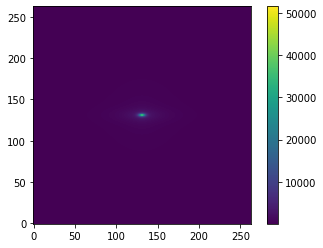

In [193]:
plt.imshow(density, origin="lower")
plt.colorbar()

In [196]:
kappa

array([[0.00730665, 0.01169064, 0.00876798, ..., 0.02045863, 0.01022931,
        0.00730665],
       [0.01315198, 0.01485009, 0.01315198, ..., 0.01169064, 0.01169064,
        0.00438399],
       [0.01477466, 0.01022931, 0.00730665, ..., 0.01022931, 0.01607464,
        0.00876798],
       ...,
       [0.02191996, 0.00876798, 0.01034527, ..., 0.00438399, 0.01753597,
        0.01315198],
       [0.0118595 , 0.02045863, 0.0189973 , ..., 0.00730665, 0.01767539,
        0.01753597],
       [0.0189973 , 0.01607464, 0.01178719, ..., 0.01169064, 0.01607464,
        0.0189973 ]])

In [197]:
density/critical_density.to(u.Msun/u.pc**2).value

array([[0.01063128, 0.01069105, 0.01075116, ..., 0.01075116, 0.01069105,
        0.01063128],
       [0.01069107, 0.01075165, 0.01081257, ..., 0.01081257, 0.01075165,
        0.01069107],
       [0.0107512 , 0.01081259, 0.01087434, ..., 0.01087434, 0.01081259,
        0.0107512 ],
       ...,
       [0.0107512 , 0.01081259, 0.01087434, ..., 0.01087434, 0.01081259,
        0.0107512 ],
       [0.01069107, 0.01075165, 0.01081257, ..., 0.01081257, 0.01075165,
        0.01069107],
       [0.01063128, 0.01069105, 0.01075116, ..., 0.01075116, 0.01069105,
        0.01063128]])

In [199]:
kappa_autolens.native

Array2D([[0.0107305 , 0.01073246, 0.01079576, ..., 0.01079576,
          0.01073246, 0.0107305 ],
         [0.01073514, 0.01073752, 0.01080152, ..., 0.01080152,
          0.01073752, 0.01073514],
         [0.01079857, 0.01080155, 0.0108664 , ..., 0.0108664 ,
          0.01080155, 0.01079857],
         ...,
         [0.01079857, 0.01080155, 0.0108664 , ..., 0.0108664 ,
          0.01080155, 0.01079857],
         [0.01073514, 0.01073752, 0.01080152, ..., 0.01080152,
          0.01073752, 0.01073514],
         [0.0107305 , 0.01073246, 0.01079576, ..., 0.01079576,
          0.01073246, 0.0107305 ]])

In [200]:
effective_einstein_radius_from_kappa(density/critical_density.to(u.Msun/u.pc**2).value
                                     , 0.09, grid=CM.Fit.imaging.unmasked.grid)

1.2083783783783781

In [186]:
critical_density.to(u.Msun/u.pc**2)

<Quantity 3377.38637237 solMass / pc2>

In [206]:
CM.Lens_model.analytic_profile

EllNFWGeneralized
centre: (0.0, 0.0)
elliptical_comps: (0.0, 5.551115123125783e-17)
kappa_s: 0.05650042207275497
scale_radius: 6.731793583456645
inner_slope: 0.9651267017008066

In [208]:
CM.Lens_model.ml

2.757446941068648